In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

query12month = '''
                select date, prcp
                from measurement
                where date >= (  select  DATE(max(date), '-12 MONTHS') 
                                  from measurement
                               )
                 order by 1
'''
pp_12month = engine.execute(query12month).fetchall()
pp_12month

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [11]:
# Save the query results as a Pandas DataFrame and set the index to the date column
pp_df = pd.DataFrame(pp_12month, columns=["Date","Precipitation"])
pp_df.set_index("Date", inplace=True,)
pp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [12]:
# Drop row with missing information
pp_df = pp_df.dropna(how='any')
pp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [13]:
# Sort the dataframe by date
pp_df = pp_df.sort_index()
pp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


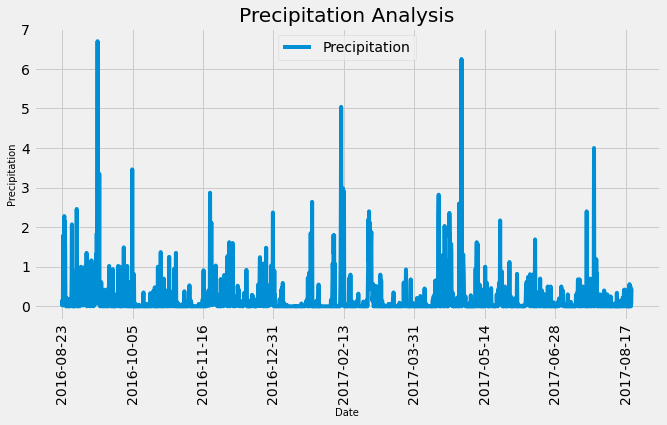

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
pp_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.xticks(rotation=90)
plt.ylabel("Precipitation", fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.legend(loc='upper center')
plt.savefig("PrecipitationAnalysis.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
pp_df.head()
station_count = session.query(Station).count()
station_count

9

In [17]:
#What are the most active stations? (i.e. what stations have the most rows)? 
#List the stations and the counts in descending order.

# create DataFrame for both the CSVs. 
queryM = '''select * from measurement'''
measurement_df = pd.read_sql_query(queryM, engine)

queryS = '''select * from station'''
station_df = pd.read_sql_query(queryS, engine)

measurement_df[['station']].groupby(['station']).size()\
                            .reset_index(name='count')\
                            .sort_values(['count'], ascending=False)

,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_st_agg_df = measurement_df.loc[measurement_df['station'] == 'USC00519281']['tobs'].agg([pd.np.min, pd.np.max, pd.np.mean])
most_active_st_agg_df
most_active_st_agg_df.values.T.tolist()

<ipython-input-18-55095f8f5769>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  most_active_st_agg_df = measurement_df.loc[measurement_df['station'] == 'USC00519281']['tobs'].agg([pd.np.min, pd.np.max, pd.np.mean])


[54.0, 85.0, 71.66378066378067]

<ipython-input-20-13777b966d14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_most_data_df['date']= pd.to_datetime(st_most_data_df['date'])


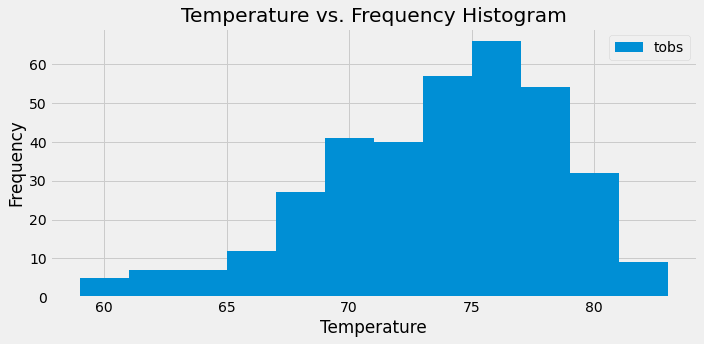

In [20]:
# Choose the station with the highest number of temperature observations.
st_most_data_df = measurement_df.loc[measurement_df['station'] == 'USC00519281']

#convert SqlLite string date to of type date in pandas
st_most_data_df.dtypes
st_most_data_df['date']= pd.to_datetime(st_most_data_df['date'])
st_most_data_df.dtypes

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date = st_most_data_df['date'].max()
most_recent_date
start_date = most_recent_date + pd.DateOffset(months=-12)
start_date
last_year_st281_df = st_most_data_df.loc[st_most_data_df['date'] >= start_date]
last_year_st281_df = last_year_st281_df[['tobs']]


last_year_st281_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Images/Temperature_vs_Frequency.png")
plt.show()